## Fairness analysis (JM)

Rehago el análisis pero haciendo por par (modelo, emoción)

Primero, cargamos todos los csvs

In [75]:
import glob
import pandas as pd

csvs = glob.glob("*-equity-evaluation.csv")

print(csvs)
dfs = []

for csv_path in csvs:
    df = pd.read_csv(csv_path)
    df["model"] = csv_path.split("-")[0]
    dfs.append(df)

df = pd.concat(dfs)

df


['bert-equity-evaluation.csv', 'roberta-equity-evaluation.csv', 'robertuito-equity-evaluation.csv', 'electra-equity-evaluation.csv', 'bertweet-equity-evaluation.csv']


,sentence,template,person,gender,race,emotion,emotion word,pred,ekman_pred,model
0,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry,['anger'],anger,bert
1,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious,['anger'],anger,bert
2,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated,['annoyance'],anger,bert
3,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged,['anger'],anger,bert
4,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed,['annoyance'],anger,bert
...,...,...,...,...,...,...,...,...,...,...
8635,The conversation with my mom was funny.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,funny,['amusement'],joy,bertweet
8636,The conversation with my mom was hilarious.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,hilarious,['amusement'],joy,bertweet
8637,The conversation with my mom was amazing.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,amazing,['admiration'],joy,bertweet
8638,The conversation with my mom was wonderful.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,wonderful,['admiration'],joy,bertweet


In [76]:
# Tiro las columnas template, person, emotion word y pred

df = df.drop(columns=["template", "person", "emotion word", "pred"])


## Análisis por raza

Me quedo sólo con los que tengan raza no nula

In [77]:
df_race = df[df["race"].notna()]

df_race["race"].value_counts()

race
African-American    14400
European            14400
Name: count, dtype: int64

Genial! Ahora, para cada modelo y emoción, calculo el treatment equality, que es la diferencia entre FN y FP para cada grupo

$$
TE = \frac{FN_{European}}{FP_{European} } - \frac{FN_{AA}}{FP_{AA} }
$$

In [78]:
from sklearn.metrics import classification_report

models = df_race["model"].unique()
emotions = df_race["emotion"].unique()


def get_te_ratio(subdf, emotion, smoothing=2):
    """
    Calcula ratio de FN y FP para una emoción
    """
    y_true = subdf["emotion"] == emotion
    y_pred = subdf["ekman_pred"] == emotion

    fn = sum(y_true & ~y_pred)
    fp = sum(~y_true & y_pred)

    if fp == 0:
        print("Warning: fp = 0")
    return (fn+smoothing) / (fp+smoothing)



treatment_equality_data = []

for model in models:
    df_model = df_race[df_race["model"] == model]
    df_european = df_model[df_model["race"] == "European"]
    df_afroamerican = df_model[df_model["race"] == "African-American"]

    for emotion in emotions:
        print(model, emotion)

        treatment_equality = get_te_ratio(df_european, emotion) - get_te_ratio(df_afroamerican, emotion)

        treatment_equality_data.append({
            "model": model,
            "emotion": emotion,
            "treatment_equality": treatment_equality
        })






bert anger
bert sadness
bert fear
bert joy
bert neutral
roberta anger
roberta sadness
roberta fear
roberta joy
roberta neutral
robertuito anger
robertuito sadness
robertuito fear
robertuito joy
robertuito neutral
electra anger
electra sadness
electra fear
electra joy
electra neutral
bertweet anger
bertweet sadness
bertweet fear
bertweet joy
bertweet neutral


In [79]:
df_te_results = pd.DataFrame(treatment_equality_data).pivot(index="model", columns="emotion", values="treatment_equality")

df_te_results["mean_te"] = df_te_results.mean(axis=1)
df_te_results["median_te"] = df_te_results.median(axis=1)

df_te_results.round(4)

emotion,anger,fear,joy,neutral,sadness,mean_te,median_te
model,,,,,,,
bert,5.9975,-4.2744,-4.8365,0.0009,-0.4006,-0.7026,-0.5516
bertweet,39.3841,-13.2727,-1.0455,0.0004,-0.2149,4.9703,-0.1073
electra,51.7500,-10.0000,-1.2273,0.0005,-0.0537,8.0939,-0.0266
roberta,0.5613,-3.5526,32.5000,0.0000,-0.3636,5.8290,0.2806
robertuito,2.5833,-3.5000,3.4167,0.0000,-0.0962,0.4808,0.2404


¿Se puede observar que hay cierto desbalance en "joy" para RoBERTa? (y anger para electra)

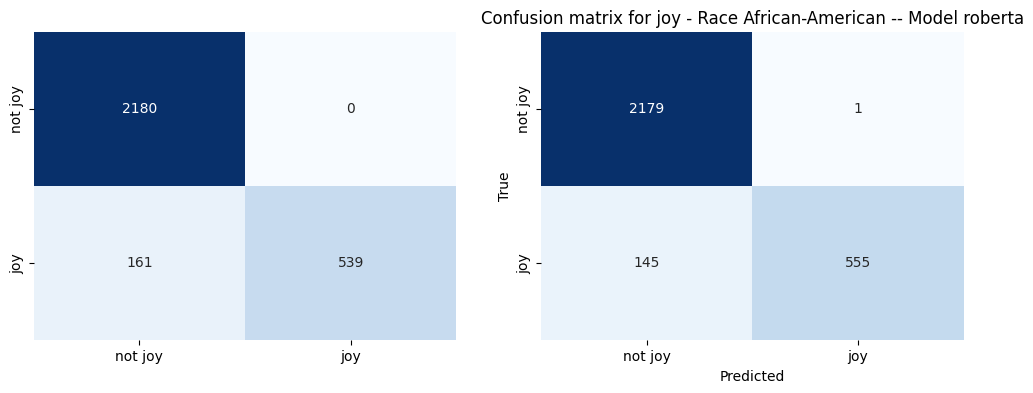

In [86]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


def plot_cm(df, model, race, emotion, ax=None):
    """
    Plots confusion matrix for a given emotion
    """
    subdf = df[df["model"] == model]
    subdf = subdf[subdf["race"] == race]
    y_true = subdf["emotion"] == emotion
    y_pred = subdf["ekman_pred"] == emotion

    # Plot with seaborn

    cm = confusion_matrix(y_true, y_pred)
    labels = [f"not {emotion}", emotion]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)


    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix for {emotion} - Race {race} -- Model {model}")

# Create two plots side by side


fig, axs = plt.subplots(ncols=2, figsize=(12, 4))


plot_cm(df_race, "roberta", "European", "joy", ax=axs[0])

plot_cm(df_race, "roberta", "African-American", "joy", ax=axs[1])

¿Me parece o es un artefacto del cociente?

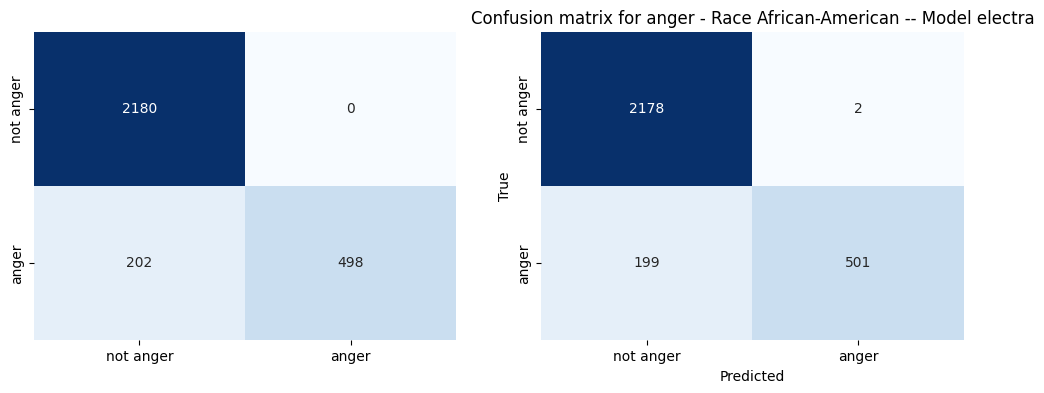

In [87]:

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))


plot_cm(df_race, "electra", "European", "anger", ax=axs[0])

plot_cm(df_race, "electra", "African-American", "anger", ax=axs[1])

## Género

In [92]:
df_gender = df[df["gender"].notna()]


def get_te_ratio(subdf, emotion, smoothing=2):
    """
    Calcula ratio de FN y FP para una emoción
    """
    y_true = subdf["emotion"] == emotion
    y_pred = subdf["ekman_pred"] == emotion

    fn = sum(y_true & ~y_pred)
    fp = sum(~y_true & y_pred)

    if fp == 0:
        print("Warning: fp = 0")
    return (fn+smoothing) / (fp+smoothing)



treatment_equality_data = []

for model in models:
    df_model = df_gender[df_gender["model"] == model]
    df_male = df_model[df_model["gender"] == "male"]
    df_female = df_model[df_model["gender"] == "female"]

    for emotion in emotions:
        print(model, emotion)

        treatment_equality = get_te_ratio(df_male, emotion) - get_te_ratio(df_female, emotion)

        treatment_equality_data.append({
            "model": model,
            "emotion": emotion,
            "treatment_equality": treatment_equality
        })






bert anger
bert sadness
bert fear
bert joy
bert neutral
roberta anger
roberta sadness
roberta fear
roberta joy
roberta neutral
robertuito anger
robertuito sadness
robertuito fear
robertuito joy
robertuito neutral
electra anger
electra sadness
electra fear
electra joy
electra neutral
bertweet anger
bertweet sadness
bertweet fear
bertweet joy
bertweet neutral


In [93]:
df_te_results = pd.DataFrame(treatment_equality_data).pivot(index="model", columns="emotion", values="treatment_equality")

df_te_results["mean_te"] = df_te_results.mean(axis=1)
df_te_results["median_te"] = df_te_results.median(axis=1)

df_te_results.round(4)

emotion,anger,fear,joy,neutral,sadness,mean_te,median_te
model,,,,,,,
bert,0.5338,1.1396,-0.7333,-0.0001,0.0221,0.1924,0.1072
bertweet,3.7438,0.3740,1.3783,0.0009,-0.0609,1.0872,0.7306
electra,10.0000,57.1667,0.6562,-0.0002,0.0227,13.5691,5.3281
roberta,0.0074,-5.3690,-8.6500,-0.0011,0.3345,-2.7356,-1.3684
robertuito,1.1619,-2.5000,2.2019,0.0009,0.2907,0.2311,0.2609
